### 生成数据集

In [10]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [11]:
def dbmoon(N=100, d=-2, r=10, w=2):
    '''生成双月数据集
    
    Args:
        N: 数据集数量
        d: 双月之间的距离
        r: 双月半径
        w: 每个月亮的厚度
        
    Returns:
        返回一个`shape=[N * 2, 2]`的数组，前100个元素表示
        上半月，后100个元素表示下半月。
    '''
    w2 = w / 2
    data = np.empty(0)
    while data.shape[0] < N:
        #generate Rectangular data
        tmp_x = 2 * (r + w2) * (np.random.random([N, 1]) - 0.5)
        tmp_y = (r + w2) * np.random.random([N, 1])
        tmp = np.concatenate((tmp_x, tmp_y), axis=1)
        tmp_ds = np.sqrt(tmp_x * tmp_x + tmp_y * tmp_y)
        #generate double moon data ---upper
        idx = np.logical_and(tmp_ds > (r - w2), tmp_ds < (r + w2))
        idx = (idx.nonzero())[0]

        if data.shape[0] == 0:
            data = tmp.take(idx, axis=0)
        else:
            data = np.concatenate((data, tmp.take(idx, axis=0)), axis=0)
    
    db_moon = data[0: N, :]
    #generate double moon data ----down
    data_t = np.empty([N, 2])
    data_t[:, 0] = data[0: N, 0] + r
    data_t[:, 1] = -data[0: N, 1] - d
    db_moon = np.concatenate((db_moon, data_t), axis=0)
    return db_moon

### 生成2500个样本并进行可视化

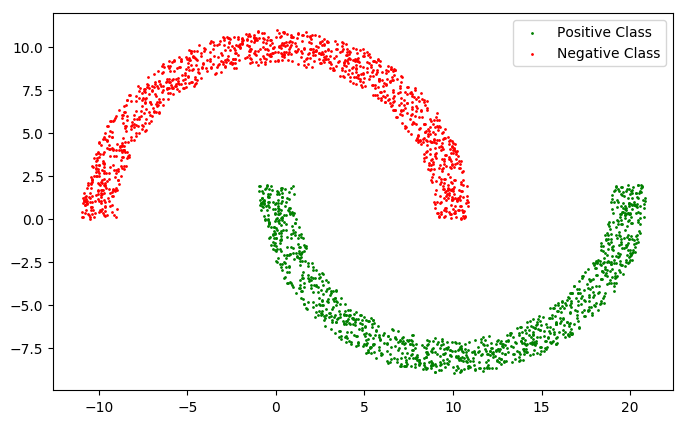

In [12]:
# 生成数据集
num_example = 2500
x =  dbmoon(N=num_example // 2)
y = np.concatenate([np.ones([num_example // 2]), -np.ones([num_example // 2])])

plt.figure(figsize=(8, 5), dpi=100)
plt.scatter(x[num_example // 2:, 0], x[num_example // 2:, 1], 1, color='green', label='Positive Class')
plt.legend(loc='best')
plt.scatter(x[: num_example // 2, 0], x[: num_example // 2, 1], 1, color='red', label='Negative Class')
plt.legend(loc='best')
plt.show()

In [23]:
# 将数据集打乱并分为训练集与测试集
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.25)

# 训练模型 20000 次
train_steps = 20000
# 摘要频率
summary_step =50
# 摘要，记录训练中的代价变化
summary = np.empty([train_steps // summary_step, 2])
# 学习率
olr = 0.2
lr=olr
# w是权值向量，b是偏置值
w = np.zeros([2], dtype=np.float32)
b = 0.

def rosenblatt(x):
    z = np.sum(w * x) + b
    if z >= 0:
        return 1
    else:
        return -1
    
def mse(label, pred):
    return np.average((np.array(label) - np.array(pred)) ** 2)


for i in range(0, train_steps):
    # 评估模型
    if i % summary_step == 0:
        test_out = []
        for j in range(test_y.shape[0]):
            test_out.append(rosenblatt(test_x[j]))
        loss = mse(test_y, test_out)
        idx = int(i / summary_step)
        summary[idx] = np.array([i, loss])
    
    # 取一个训练集中的样本
    one_x, one_y = train_x[i % train_y.shape[0]], train_y[i % train_y.shape[0]]
    # 得到模型输出结果
    out = rosenblatt(one_x )
    # 更新权值
    w = w + lr * (one_y - out) * (one_x)
    b = b + lr * (one_y - out)

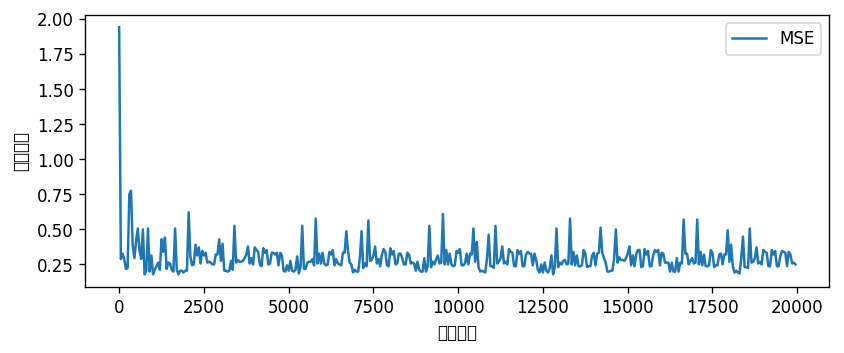

In [24]:
plt.figure(figsize=(8, 3), dpi=120)

plt.plot(summary[:, 0], summary[:, 1], label='MSE')
plt.legend(loc='best')
plt.xlabel('迭代次数', fontproperties='SimHei')
plt.ylabel('均方误差', fontproperties='SimHei')
#代价为训练代价
plt.show()

### 不收敛

### 使用学习率衰减


In [29]:
from keras.callbacks import LearningRateScheduler
from math import pow, floor

In [32]:
def step_decay(epoch):
    olr = 0.2#初始学习率定为0.1
    drop = 0.3#学习率降低30%
    epochs_drop = 10#没10个epochs降低一次
    lr = olr * pow(drop, floor(1 + epoch) / epochs_drop)
    return lr


In [33]:
lr = LearningRateScheduler(step_decay)

In [34]:
# 将数据集打乱并分为训练集与测试集
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.25)

# 训练模型 20000 次
train_steps = 20000
# 摘要频率
summary_step =50
# 摘要，记录训练中的代价变化
summary = np.empty([train_steps // summary_step, 2])
# 学习率
olr = 0.2
lr=step_decay(train_steps)
# w是权值向量，b是偏置值
w = np.zeros([2], dtype=np.float32)
b = 0.

def rosenblatt(x):
    z = np.sum(w * x) + b
    if z >= 0:
        return 1
    else:
        return -1
    
def mse(label, pred):
    return np.average((np.array(label) - np.array(pred)) ** 2)


for i in range(0, train_steps):
    # 评估模型
    if i % summary_step == 0:
        test_out = []
        for j in range(test_y.shape[0]):
            test_out.append(rosenblatt(test_x[j]))
        loss = mse(test_y, test_out)
        idx = int(i / summary_step)
        summary[idx] = np.array([i, loss])
    
    # 取一个训练集中的样本
    one_x, one_y = train_x[i % train_y.shape[0]], train_y[i % train_y.shape[0]]
    # 得到模型输出结果
    out = rosenblatt(one_x )
    # 更新权值
    w = w + lr * (one_y - out) * (one_x)
    b = b + lr * (one_y - out)

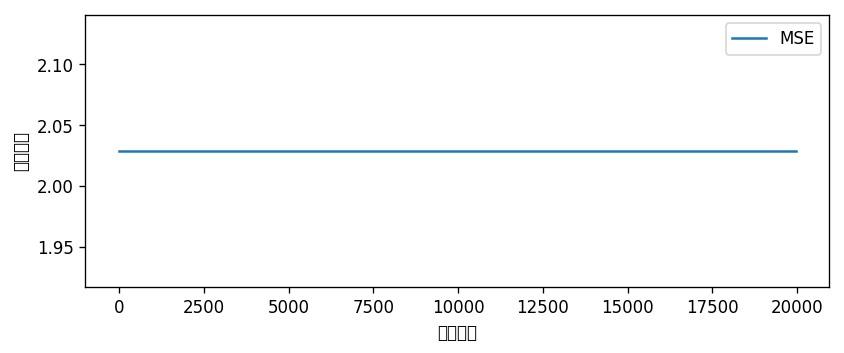

In [35]:
plt.figure(figsize=(8, 3), dpi=120)

plt.plot(summary[:, 0], summary[:, 1], label='MSE')
plt.legend(loc='best')
plt.xlabel('迭代次数', fontproperties='SimHei')
plt.ylabel('均方误差', fontproperties='SimHei')
#代价为训练代价
plt.show()